In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
import plotly.express as px
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/dataset/data.csv'
df = pd.read_csv(file_path, parse_dates=['DATE_'])
print(f"✅ Data loaded. Shape: {df.shape}")

/tmp/ipython-input-2033938930.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, parse_dates=['DATE_'])


✅ Data loaded. Shape: (3039372, 40)


In [ ]:
# 1️⃣ Tổng số khách hàng duy nhất
num_customers = df['USERID'].nunique()

# 2️⃣ Tổng doanh thu toàn bộ
total_revenue = df['TOTALPRICE'].sum()

# 3️⃣ Tổng số sản phẩm duy nhất
num_products = df['ITEMID'].nunique()

# 4️⃣ Tổng số dòng (giao dịch)
num_transactions = len(df)

print(f"🧍‍♂️ Số lượng khách hàng duy nhất: {num_customers:,}")
print(f"💰 Tổng doanh thu: {total_revenue:,.2f}")
print(f"📦 Số lượng sản phẩm duy nhất: {num_products:,}")
print(f"🧾 Tổng số giao dịch: {num_transactions:,}")

🧍‍♂️ Số lượng khách hàng duy nhất: 55,206
💰 Tổng doanh thu: 865,026,802.13
📦 Số lượng sản phẩm duy nhất: 27,000
🧾 Tổng số giao dịch: 3,039,372


# Dự đoán doanh thu 6 tháng tới theo danh mục sản phẩm

In [ ]:
DATE_COL = 'DATE_'
SALES_COL = 'TOTALPRICE'  # Sử dụng TOTALPRICE làm biến Sales để dự đoán
CATEGORY_COL = 'CATEGORY1'

## Xoá các dữ liệu thiếu DATE_

In [ ]:
df_clean = df.dropna(subset=[DATE_COL, SALES_COL, CATEGORY_COL]).copy()
df_clean[DATE_COL] = pd.to_datetime(df_clean[DATE_COL])
df_clean.shape

(1556770, 41)

In [ ]:
df_clean['YearMonth'] = df_clean[DATE_COL].dt.to_period('M').astype(str)

## Tổng hợp dữ liệu

In [ ]:
df_monthly = (
    df_clean.groupby([CATEGORY_COL, pd.Grouper(key=DATE_COL, freq='M')])[SALES_COL]
    .sum()
    .reset_index()
    .rename(columns={DATE_COL: 'ds', SALES_COL: 'y'}) # Đổi tên cột cho Prophet
)

/tmp/ipython-input-1275409237.py:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



## Top 5 danh mục hàng đầu

In [ ]:
top_categories = df_monthly.groupby(CATEGORY_COL)['y'].sum().nlargest(5).index.tolist()
df_monthly = df_monthly[df_monthly[CATEGORY_COL].isin(top_categories)]

print(f"✅ Đã chuẩn bị dữ liệu cho {len(top_categories)} danh mục hàng đầu: {', '.join(top_categories)}")

✅ Đã chuẩn bị dữ liệu cho 5 danh mục hàng đầu: Home, Cosmetics, Toy, Food, Detergent


In [ ]:
print("\nB3: Vẽ biểu đồ xu hướng doanh thu qua thời gian...")
fig_history = px.line(
    df_monthly,
    x='ds',
    y='y',
    color=CATEGORY_COL,
    title='Xu hướng Doanh thu Lịch sử Theo Danh mục (TOTALPRICE)'
)
fig_history.show()


B3: Vẽ biểu đồ xu hướng doanh thu qua thời gian...


## Xây dựng mô hình dự đoán

In [ ]:
print("\nXây dựng mô hình và Triển khai dự đoán 6 tháng...")
HORIZON = 6  # Dự đoán 6 tháng

forecast_results = pd.DataFrame() # Initialize forecast_results here
for category in top_categories:
    df_cat = df_monthly[df_monthly[CATEGORY_COL] == category][['ds', 'y']]

    if len(df_cat) < 12:
        print(f"⚠️ Dữ liệu cho {category} quá ngắn ({len(df_cat)} tháng). Bỏ qua.")
        continue

    # Khởi tạo và Huấn luyện mô hình
    m = Prophet(
        yearly_seasonality=True,
        seasonality_mode='multiplicative'
    )
    m.fit(df_cat)

    # Tạo DataFrame tương lai (6 tháng tiếp theo)
    future = m.make_future_dataframe(periods=HORIZON, freq='M')

    # Dự đoán
    forecast = m.predict(future)

    # Lấy 6 tháng dự đoán cuối cùng
    last_date = df_cat['ds'].max()
    forecast_6_months = forecast[forecast['ds'] > last_date][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast_6_months[CATEGORY_COL] = category
    forecast_6_months = forecast_6_months.rename(columns={'yhat': 'Predicted Sales'})

    print(f"   -> Số lượng dự đoán 6 tháng thực tế được tạo: {len(forecast_6_months)}")

    if len(forecast_6_months) == 0:
        print(f"❌ CẢNH BÁO: Không thể tạo dự đoán tương lai (kết quả rỗng) cho {category}. Bỏ qua.")
        continue

    # Concatenate the forecast results within the loop
    forecast_results = pd.concat([forecast_results, forecast_6_months], ignore_index=True)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsrlnr04v/wmq5na6w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsrlnr04v/zpczovq9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91567', 'data', 'file=/tmp/tmpsrlnr04v/wmq5na6w.json', 'init=/tmp/tmpsrlnr04v/zpczovq9.json', 'output', 'file=/tmp/tmpsrlnr04v/prophet_modelua4fcuxy/prophet_model-20251019064445.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:44:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:44:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:


Xây dựng mô hình và Triển khai dự đoán 6 tháng...


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsrlnr04v/x5wl6il9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsrlnr04v/rte44ke8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20914', 'data', 'file=/tmp/tmpsrlnr04v/x5wl6il9.json', 'init=/tmp/tmpsrlnr04v/rte44ke8.json', 'output', 'file=/tmp/tmpsrlnr04v/prophet_modelsaut8b07/prophet_model-20251019064445.csv', 'method=optimize', 'algorithm=newton', 'iter

   -> Số lượng dự đoán 6 tháng thực tế được tạo: 6


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsrlnr04v/96jbdtey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsrlnr04v/7z1cg8s_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72846', 'data', 'file=/tmp/tmpsrlnr04v/96jbdtey.json', 'init=/tmp/tmpsrlnr04v/7z1cg8s_.json', 'output', 'file=/tmp/tmpsrlnr04v/prophet_modelgz4ngz68/prophet_model-20251019064446.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:44:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


   -> Số lượng dự đoán 6 tháng thực tế được tạo: 6


06:44:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsrlnr04v/ao6vkw45.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsrlnr04v/plrsd42o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88288', 'data', 'file=/tmp/tmpsrlnr04v/ao6vkw45.json', 'init=/tmp/tmpsrlnr04v/plrsd42o.json', 'output', 'file=/tmp/tmpsrlnr04v/prop

   -> Số lượng dự đoán 6 tháng thực tế được tạo: 6


06:44:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsrlnr04v/ryqf73ww.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsrlnr04v/pewkum5a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61264', 'data', 'file=/tmp/tmpsrlnr04v/ryqf73ww.json', 'init=/tmp/tmpsrlnr04v/pewkum5a.json', 'output', 'file=/tmp/tmpsrlnr04v/prop

   -> Số lượng dự đoán 6 tháng thực tế được tạo: 6


06:44:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


   -> Số lượng dự đoán 6 tháng thực tế được tạo: 6


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



## Tạo DataFrame tương lai

In [ ]:
# Tạo DataFrame tương lai (6 tháng tiếp theo)
future = m.make_future_dataframe(periods=HORIZON, freq='ME')

# Dự đoán
forecast = m.predict(future)

## Trực quan hoá

In [ ]:
print("\n" + "="*70)
print("DỰ ĐOÁN DOANH THU 6 THÁNG TỚI THEO DANH MỤC (Tổng TOTALPRICE)")
print("="*70)

# THÊM DÒNG NÀY: Chuyển đổi cột 'ds' sang datetime để sử dụng .dt accessor
forecast_results['ds'] = pd.to_datetime(forecast_results['ds'])

# Định dạng kết quả dự đoán cuối cùng
forecast_results['ds'] = forecast_results['ds'].dt.strftime('%Y-%m')
forecast_results['Predicted Sales'] = forecast_results['Predicted Sales'].round(0).astype(int)
forecast_results['Khoảng tin cậy tối thiểu'] = forecast_results['yhat_lower'].round(0).astype(int)
forecast_results['Khoảng tin cậy tối đa'] = forecast_results['yhat_upper'].round(0).astype(int)

final_table = forecast_results[[
    'ds', CATEGORY_COL, 'Predicted Sales',
    'Khoảng tin cậy tối thiểu', 'Khoảng tin cậy tối đa'
]].rename(columns={'ds': 'Thời gian (Tháng)'})

print(final_table.to_markdown(index=False))

# Trực quan hóa kết quả dự đoán (So sánh thực tế vs dự đoán)
df_plot = df_monthly.copy()
df_plot['Type'] = 'Historical Sales'

df_forecast_plot = forecast_results.rename(columns={'Predicted Sales': 'y'})
# Sửa lỗi: Sử dụng tên cột gốc 'ds' và chuyển đổi nó từ chuỗi sang datetime để vẽ
df_forecast_plot['ds'] = pd.to_datetime(df_forecast_plot['ds'])
df_forecast_plot['Type'] = 'Predicted Sales'

combined_df = pd.concat([df_plot[['ds', 'y', CATEGORY_COL, 'Type']],
                         df_forecast_plot[['ds', 'y', CATEGORY_COL, 'Type']]], ignore_index=True)

fig_forecast = px.line(
    combined_df,
    x='ds',
    y='y',
    color=CATEGORY_COL,
    line_dash='Type',
    title='Dự đoán Doanh thu (Sales) theo Danh mục - Lịch sử và Dự báo'
)

fig_forecast.update_layout(
    xaxis_title="Thời gian (Tháng)",
    yaxis_title="Doanh thu (Tổng TOTALPRICE)",
    legend_title="Danh mục / Loại dữ liệu"
)

fig_forecast.show()


DỰ ĐOÁN DOANH THU 6 THÁNG TỚI THEO DANH MỤC (Tổng TOTALPRICE)
| Thời gian (Tháng)   | CATEGORY1   |   Predicted Sales |   Khoảng tin cậy tối thiểu |   Khoảng tin cậy tối đa |
|:--------------------|:------------|------------------:|---------------------------:|------------------------:|
| 2023-09             | Home        |           4129474 |                    3932106 |                 4340933 |
| 2023-10             | Home        |           4980770 |                    4781655 |                 5193631 |
| 2023-11             | Home        |           3822820 |                    3610431 |                 4032166 |
| 2023-12             | Home        |           3516809 |                    3322451 |                 3707650 |
| 2024-01             | Home        |           3488794 |                    3293984 |                 3691513 |
| 2024-02             | Home        |           3447447 |                    3243739 |                 3644091 |
| 2023-09             | Cosmetics

## Đánh giá độ chính xác của mô hình

In [ ]:
def run_accuracy_evaluation(df_monthly, top_categories, TEST_PERIOD=6):
    """Tính toán MAE và MAPE trên 6 tháng cuối của dữ liệu lịch sử."""

    accuracy_metrics = []

    for category in top_categories:
        df_cat = df_monthly[df_monthly[CATEGORY_COL] == category][['ds', 'y']]

        # Yêu cầu ít nhất 18 tháng (1 năm Train + 6 tháng Test) để đánh giá đáng tin cậy
        if len(df_cat) < TEST_PERIOD + 12:
            continue

        # Chia tập dữ liệu thành Train và Test
        df_train = df_cat.iloc[:-TEST_PERIOD]
        df_test = df_cat.iloc[-TEST_PERIOD:]

        # Huấn luyện mô hình Prophet trên tập Train
        m = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative')
        m.fit(df_train)

        # Dự đoán trên Giai đoạn Test
        future = m.make_future_dataframe(periods=TEST_PERIOD, freq='M', include_history=False)
        forecast = m.predict(future)

        y_true = df_test['y'].values
        y_pred = forecast['yhat'].values

        # Tính Metrics
        mae = mean_absolute_error(y_true, y_pred)

        non_zero_indices = y_true != 0
        y_true_nz = y_true[non_zero_indices]
        y_pred_nz = y_pred[non_zero_indices]

        mape = mean_absolute_percentage_error(y_true_nz, y_pred_nz) * 100

        accuracy_metrics.append({
            'CATEGORY1': category,
            'MAE': round(mae, 0),
            'MAPE (%)': round(mape, 2)
        })

    # Hiển thị Kết quả Đánh giá
    df_accuracy = pd.DataFrame(accuracy_metrics)

    print("\n" + "—"*70)
    print(f"ĐỘ CHÍNH XÁC DỰ ĐOÁN ĐỊNH LƯỢNG (Đánh giá trên {TEST_PERIOD} tháng cuối lịch sử)")
    print("—"*70)

    if df_accuracy.empty:
        print("Không đủ dữ liệu lịch sử (ít nhất 18 tháng) để thực hiện đánh giá định lượng cho các danh mục.")
    else:
        print(df_accuracy.to_markdown(index=False))


# Gọi hàm đánh giá sau khi đã chuẩn bị dữ liệu
run_accuracy_evaluation(df_monthly, top_categories, TEST_PERIOD=HORIZON)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsrlnr04v/zj6txcv9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsrlnr04v/85x7kl27.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83030', 'data', 'file=/tmp/tmpsrlnr04v/zj6txcv9.json', 'init=/tmp/tmpsrlnr04v/85x7kl27.json', 'output', 'file=/tmp/tmpsrlnr04v/prophet_modelz6k10gng/prophet_model-20251019064454.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:44:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:44:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:


——————————————————————————————————————————————————————————————————————
ĐỘ CHÍNH XÁC DỰ ĐOÁN ĐỊNH LƯỢNG (Đánh giá trên 6 tháng cuối lịch sử)
——————————————————————————————————————————————————————————————————————
| CATEGORY1   |    MAE |   MAPE (%) |
|:------------|-------:|-----------:|
| Home        | 601023 |      22    |
| Cosmetics   | 302801 |      18.81 |
| Toy         | 504149 |      28.7  |
| Food        | 334480 |      53.2  |
| Detergent   | 199222 |      29.4  |


# Dự đoán doanh thu 6 tháng tới theo khu vực

In [ ]:
DATE_COL = 'DATE_'
SALES_COL = 'TOTALPRICE'
GROUP_COL = 'REGION'

In [ ]:
# Lấy danh sách các cột REGION (ví dụ: 'REG_Marmara')
reg_cols = [col for col in df.columns if col.startswith('REG_')]

# Hàm để lấy tên khu vực từ các cột bool (chỉ khu vực có giá trị True)
def get_region_name(row):
    for col in reg_cols:
        if row[col]:
            return col.replace('REG_', '') # Ví dụ: 'REG_Marmara' -> 'Marmara'
    return 'Unknown' # Trả về 'Unknown' nếu không có khu vực nào True

# Tạo cột GROUP_COL mới ('REGION')
df[GROUP_COL] = df.apply(get_region_name, axis=1)

## Xoá các dữ liệu thiếu DATE_

In [ ]:
df_clean = df.dropna(subset=[DATE_COL, SALES_COL, GROUP_COL]).copy()

df_clean[DATE_COL] = pd.to_datetime(df_clean[DATE_COL])
df_clean.shape

(1556770, 41)

## Tổng hợp dữ liệu

In [ ]:
df_monthly = (
    df_clean.groupby([GROUP_COL, pd.Grouper(key=DATE_COL, freq='M')])[SALES_COL]
    .sum()
    .reset_index()
    .rename(columns={DATE_COL: 'ds', SALES_COL: 'y'})
)

/tmp/ipython-input-3083302383.py:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



## Top 5 khu vực hàng đầu

In [ ]:
top_groups = df_monthly.groupby(GROUP_COL)['y'].sum().nlargest(5).index.tolist()
df_monthly = df_monthly[df_monthly[GROUP_COL].isin(top_groups)]

print(f"✅ Đã chuẩn bị dữ liệu cho {len(top_groups)} khu vực hàng đầu: {', '.join(top_groups)}")

✅ Đã chuẩn bị dữ liệu cho 5 khu vực hàng đầu: Ic Anadolu, Marmara, Karadeniz, Akdeniz, Ege


In [ ]:
print("\nB3: Vẽ biểu đồ xu hướng doanh thu qua thời gian...")
fig_history = px.line(
    df_monthly,
    x='ds',
    y='y',
    color=GROUP_COL,
    title='Xu hướng Doanh thu Lịch sử Theo Khu vực (TOTALPRICE)'
)
fig_history.show()


B3: Vẽ biểu đồ xu hướng doanh thu qua thời gian...


## Xây dựng mô hình dự đoán

In [ ]:


print("\nB5 & B7: Xây dựng mô hình và Triển khai dự đoán 12 tháng...")
HORIZON = 12  # Dự đoán 12 tháng

all_forecasts = []  # Initialize the list here

for group in top_groups:
    df_cat = df_monthly[df_monthly[GROUP_COL] == group][['ds', 'y']]

    if len(df_cat) < 1:
        print(f"⚠️ Không có dữ liệu để dự đoán cho khu vực {group}.")
        continue

    # Huấn luyện mô hình
    m = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative',changepoint_prior_scale=0.3)
    try:
        m.fit(df_cat)
    except Exception as e:
        print(f"❌ LỖI KHÔNG THỂ HUẤN LUYỆN MÔ HÌNH cho khu vực {group}: {e}")
        continue

    # Dự đoán 12 tháng tương lai
    future = m.make_future_dataframe(periods=HORIZON, freq='M')
    forecast = m.predict(future)

    last_date = df_cat['ds'].max()
    forecast_months = forecast[forecast['ds'] > last_date][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    if len(forecast_months) == 0:
        continue

    forecast_months[GROUP_COL] = group
    forecast_months = forecast_months.rename(columns={'yhat': 'Predicted Sales'})

    all_forecasts.append(forecast_months)

# Nối tất cả các kết quả dự đoán lại
forecast_results = pd.concat(all_forecasts, ignore_index=True) if all_forecasts else pd.DataFrame()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsrlnr04v/sdornr5l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsrlnr04v/syub5u2_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46173', 'data', 'file=/tmp/tmpsrlnr04v/sdornr5l.json', 'init=/tmp/tmpsrlnr04v/syub5u2_.json', 'output', 'file=/tmp/tmpsrlnr04v/prophet_modelq4hr978a/prophet_model-20251019064802.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:48:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



B5 & B7: Xây dựng mô hình và Triển khai dự đoán 12 tháng...


06:48:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsrlnr04v/vhl7b9oa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsrlnr04v/4vqa86jd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59985', 'data', 'file=/tmp/tmpsrlnr04v/vhl7b9oa.json', 'init=/tmp/tmpsrlnr04v/4vqa86jd.json', 'output', 'file=/tmp/tmpsrlnr04v/prop

## Trực quan hoá

In [ ]:
print("\n" + "="*70)
print(f"DỰ ĐOÁN DOANH THU {HORIZON} THÁNG TỚI THEO KHU VỰC (Tổng TOTALPRICE)")
print("="*70)

forecast_results['ds'] = pd.to_datetime(forecast_results['ds'])
forecast_results['ds'] = forecast_results['ds'].dt.strftime('%Y-%m')

# Định dạng bảng
forecast_results['Predicted Sales'] = forecast_results['Predicted Sales'].round(0).astype(int)
forecast_results['Khoảng tin cậy tối thiểu'] = forecast_results['yhat_lower'].round(0).astype(int)
forecast_results['Khoảng tin cậy tối đa'] = forecast_results['yhat_upper'].round(0).astype(int)

final_table = forecast_results[[
    'ds', GROUP_COL, 'Predicted Sales',
    'Khoảng tin cậy tối thiểu', 'Khoảng tin cậy tối đa'
]].rename(columns={'ds': 'Thời gian (Tháng)', GROUP_COL: 'Khu vực'})

print(final_table.to_markdown(index=False))

# Trực quan hóa kết quả dự đoán
df_plot = df_monthly.copy()
df_plot['Type'] = 'Historical Sales'
df_forecast_plot = forecast_results.rename(columns={'Predicted Sales': 'y'})

# Use the original 'ds' column for plotting
df_forecast_plot['ds'] = pd.to_datetime(df_forecast_plot['ds'])
df_forecast_plot = df_forecast_plot.rename(columns={'Khu vực': GROUP_COL})
df_forecast_plot['Type'] = 'Predicted Sales'

combined_df = pd.concat([df_plot[['ds', 'y', GROUP_COL, 'Type']],
                         df_forecast_plot[['ds', 'y', GROUP_COL, 'Type']]], ignore_index=True)

fig_forecast = px.line(
    combined_df,
    x='ds',
    y='y',
    color=GROUP_COL,
    line_dash='Type',
    title='Dự đoán Doanh thu (Sales) theo Khu vực - Lịch sử và Dự báo'
)

fig_forecast.update_layout(
    xaxis_title="Thời gian (Tháng)",
    yaxis_title="Doanh thu (Tổng TOTALPRICE)",
    legend_title="Khu vực / Loại dữ liệu"
)

fig_forecast.show()


DỰ ĐOÁN DOANH THU 12 THÁNG TỚI THEO KHU VỰC (Tổng TOTALPRICE)
| Thời gian (Tháng)   | Khu vực    |   Predicted Sales |   Khoảng tin cậy tối thiểu |   Khoảng tin cậy tối đa |
|:--------------------|:-----------|------------------:|---------------------------:|------------------------:|
| 2023-09             | Ic Anadolu |           3966560 |                    3691615 |                 4218217 |
| 2023-10             | Ic Anadolu |           4006026 |                    3752647 |                 4249451 |
| 2023-11             | Ic Anadolu |           3632618 |                    3372410 |                 3878388 |
| 2023-12             | Ic Anadolu |           3447070 |                    3208907 |                 3700254 |
| 2024-01             | Ic Anadolu |           3437075 |                    3193460 |                 3683892 |
| 2024-02             | Ic Anadolu |           3164743 |                    2913430 |                 3441442 |
| 2024-03             | Ic Anadolu |     

## Đánh giá độ chinh xác của mô hình

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from prophet import Prophet
import pandas as pd
import numpy as np

def run_accuracy_evaluation_final(df_monthly, top_groups, TEST_PERIOD=12):
    """Tính toán MAE và MAPE với chiến lược ổn định xu hướng và xử lý ngoại lai."""

    accuracy_metrics = []

    # ⭐️ THAM SỐ CUỐI CÙNG: ỔN ĐỊNH LẠI MÔ HÌNH VÀ GIỮ TÍNH THỜI VỤ CAO
    SCALE = 0.25 # Giảm độ linh hoạt để tránh Overfitting
    FOURIER = 15 # Giữ tính thời vụ cao

    # Giới hạn trên để xử lý ngoại lai (95th percentile)
    CAPPING_PERCENTILE = 0.95

    for group in top_groups:
        df_cat = df_monthly[df_monthly[GROUP_COL] == group][['ds', 'y']].copy()

        if len(df_cat) < TEST_PERIOD + 12:
            continue

        df_train = df_cat.iloc[:-TEST_PERIOD].copy()
        df_test = df_cat.iloc[-TEST_PERIOD:].copy()

        # ⭐️ BƯỚC XỬ LÝ NGOẠI LAI (CAPPING)
        threshold = df_train['y'].quantile(CAPPING_PERCENTILE)
        df_train['y'] = np.where(df_train['y'] > threshold, threshold, df_train['y'])

        # -------------------------------------------------------------------

        # Huấn luyện mô hình Prophet trên tập Train đã được làm sạch
        m = Prophet(
            seasonality_mode='multiplicative',
            changepoint_prior_scale=SCALE
        )
        m.add_seasonality(name='yearly', period=365.25, fourier_order=FOURIER)

        m.fit(df_train)

        # Dự đoán và Đánh giá... (Phần này giữ nguyên)
        future = m.make_future_dataframe(periods=TEST_PERIOD, freq='ME', include_history=False)
        forecast = m.predict(future)

        y_true = df_test['y'].values
        y_pred = forecast['yhat'].values

        # Tính Metrics
        mae = mean_absolute_error(y_true, y_pred)

        non_zero_indices = y_true != 0
        y_true_nz = y_true[non_zero_indices]
        y_pred_nz = y_pred[non_zero_indices]

        # Tính MAPE
        if len(y_true_nz) > 0:
            mape = mean_absolute_percentage_error(y_true_nz, y_pred_nz) * 100
        else:
            mape = float('nan')

        accuracy_metrics.append({
            'Khu vực': group,
            'MAE': round(mae, 0),
            'MAPE (%)': round(mape, 2)
        })

    # Hiển thị Kết quả Đánh giá
    df_accuracy = pd.DataFrame(accuracy_metrics)

    print("\n" + "—"*70)
    print(f"ĐỘ CHÍNH XÁC DỰ ĐOÁN ĐỊNH LƯỢNG (Đánh giá trên {TEST_PERIOD} tháng cuối lịch sử)")
    print("—"*70)

    if df_accuracy.empty:
        print(f"Không đủ dữ liệu lịch sử (ít nhất {TEST_PERIOD + 12} tháng) để thực hiện đánh giá định lượng cho các khu vực.")
    else:
        print(f"Tham số sử dụng: changepoint_prior_scale={SCALE}, fourier_order={FOURIER}, Capping={CAPPING_PERCENTILE}")
        print(df_accuracy.to_markdown(index=False))

# Gọi hàm đánh giá độ chính xác sau khi đã định nghĩa hàm ở trên
run_accuracy_evaluation_final(df_monthly, top_groups, TEST_PERIOD=HORIZON)

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsrlnr04v/d6r87u0z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsrlnr04v/6p7pv41p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85010', 'data', 'file=/tmp/tmpsrlnr04v/d6r87u0z.json', 'init=/tmp/tmpsrlnr04v/6p7pv41p.json', 'output', 'file=/tmp/tmpsrlnr04v/prophet_model_vg8h19i/prophet_model-20251019075811.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:58:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmd


——————————————————————————————————————————————————————————————————————
ĐỘ CHÍNH XÁC DỰ ĐOÁN ĐỊNH LƯỢNG (Đánh giá trên 12 tháng cuối lịch sử)
——————————————————————————————————————————————————————————————————————
Tham số sử dụng: changepoint_prior_scale=0.25, fourier_order=15, Capping=0.95
| Khu vực    |    MAE |   MAPE (%) |
|:-----------|-------:|-----------:|
| Ic Anadolu | 755599 |      21.95 |
| Marmara    | 476026 |      26.41 |
| Karadeniz  | 515491 |      30.95 |
| Akdeniz    | 548762 |      35.13 |
| Ege        | 319864 |      23.37 |


# Phân khúc khách hàng

## Xác định ngày mốc

In [ ]:
snapshot_date = df['DATE_'].max() + pd.Timedelta(days=1)

## Tính toán RFM

In [ ]:
# 2. Tính toán RFM
rfm_df = df.groupby('USERID').agg(
    # Recency: Tính số ngày từ ngày mua hàng cuối cùng
    Recency=('DATE_', lambda x: (snapshot_date - x.max()).days),

    # Frequency: Đếm số lượng đơn hàng duy nhất
    Frequency=('ORDERID', 'nunique'),

    # Monetary: Tính tổng chi tiêu
    Monetary=('TOTALPRICE', 'sum')
).reset_index()

print("\n--- Bảng RFM ban đầu ---")
print(rfm_df.to_markdown(index=False))

Streaming output truncated to the last 5000 lines.
|    91048 |        10 |           3 |   40005.3  |
|    91050 |       847 |           1 |   11288.9  |
|    91051 |       643 |           1 |    1457.52 |
|    91055 |        25 |           1 |    8461.05 |
|    91057 |        10 |           1 |    3617.2  |
|    91058 |        26 |           1 |   20763.9  |
|    91059 |       292 |           2 |   25395    |
|    91060 |       313 |           1 |     634.8  |
|    91062 |       417 |           1 |   10586.6  |
|    91063 |        40 |           2 |   16200.4  |
|    91065 |       501 |           1 |     980    |
|    91068 |       821 |           1 |   10370.8  |
|    91070 |       813 |           1 |   17584.6  |
|    91071 |        41 |           1 |     208.4  |
|    91072 |       238 |           3 |   26388.1  |
|    91073 |       296 |           1 |    7486    |
|    91074 |       117 |           1 |    4880.5  |
|    91075 |       706 |           1 |      58.1  |
|    91078 | 

## Chuẩn hoá dữ liệu

In [ ]:
# 1. Xử lý lệch dữ liệu (Skewness) bằng Log Transformation
rfm_log = rfm_df[['Recency', 'Frequency', 'Monetary']].apply(np.log1p)

# 2. Chuẩn hóa dữ liệu (Standardization)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=rfm_log.columns)

## Vẽ biểu đồ Elbow Method

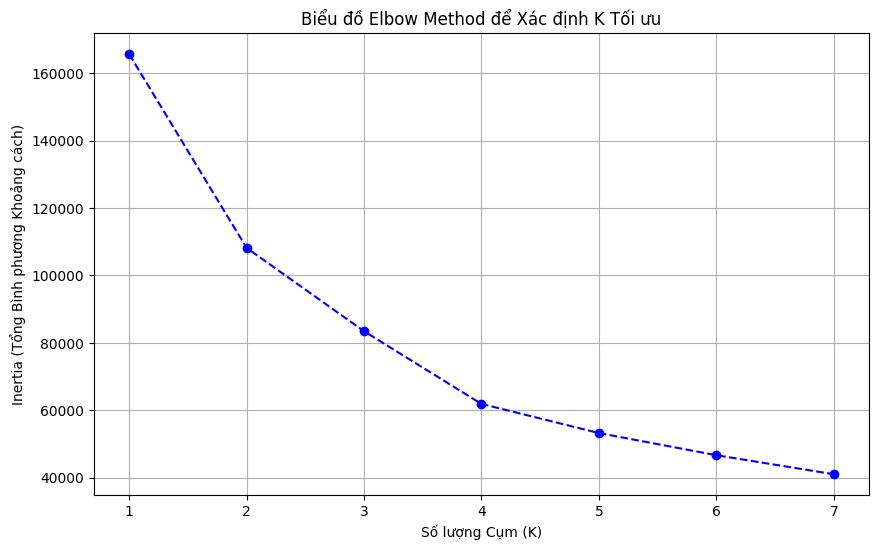

In [ ]:
inertia = []

for k in range(1, 8):
     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
     kmeans.fit(rfm_scaled_df)
     inertia.append(kmeans.inertia_)

k_range = np.arange(1, len(inertia) + 1)
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--', color='blue')
plt.title('Biểu đồ Elbow Method để Xác định K Tối ưu')
plt.xlabel('Số lượng Cụm (K)')
plt.ylabel('Inertia (Tổng Bình phương Khoảng cách)')
plt.xticks(k_range)
plt.grid(True)
plt.show()


## Xây dựng và huấn luyện mô hình

In [ ]:
K_CLUSTERS = 4
kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init=10)
rfm_df['Segment'] = kmeans.fit_predict(rfm_scaled_df)


In [ ]:
# Phân tích giá trị trung bình của RFM (dùng giá trị gốc, không log) cho mỗi phân khúc
segment_analysis = rfm_df.groupby('Segment').agg(
    Count=('USERID', 'count'),
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_Monetary=('Monetary', 'mean')
).reset_index()

In [ ]:
# Tính tỷ lệ phần trăm khách hàng
segment_analysis['Pct_of_Customers'] = (segment_analysis['Count'] / segment_analysis['Count'].sum()) * 100

print("\n--- BẢNG PHÂN TÍCH ĐẶC ĐIỂM CÁC PHÂN KHÚC ---")
# Làm tròn và in kết quả
segment_analysis[['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary']] = segment_analysis[['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary']].round(2)
segment_analysis['Pct_of_Customers'] = segment_analysis['Pct_of_Customers'].round(2)

print(segment_analysis.sort_values(by='Avg_Monetary', ascending=False).to_markdown(index=False))


--- BẢNG PHÂN TÍCH ĐẶC ĐIỂM CÁC PHÂN KHÚC ---
|   Segment |   Count |   Avg_Recency |   Avg_Frequency |   Avg_Monetary |   Pct_of_Customers |
|----------:|--------:|--------------:|----------------:|---------------:|-------------------:|
|         0 |   15552 |        339.89 |            2.36 |       13322.4  |              28.17 |
|         2 |   19189 |        534.29 |            1    |        9113.5  |              34.76 |
|         3 |    6575 |         44.22 |            1.57 |        7972.72 |              11.91 |
|         1 |   13890 |        505.9  |            1.05 |         657.8  |              25.16 |


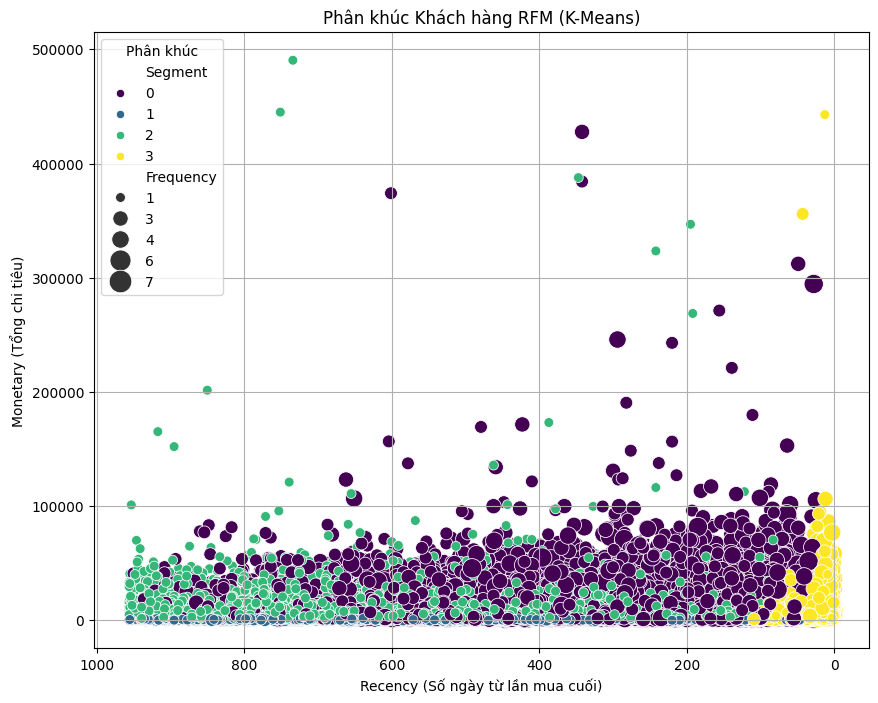

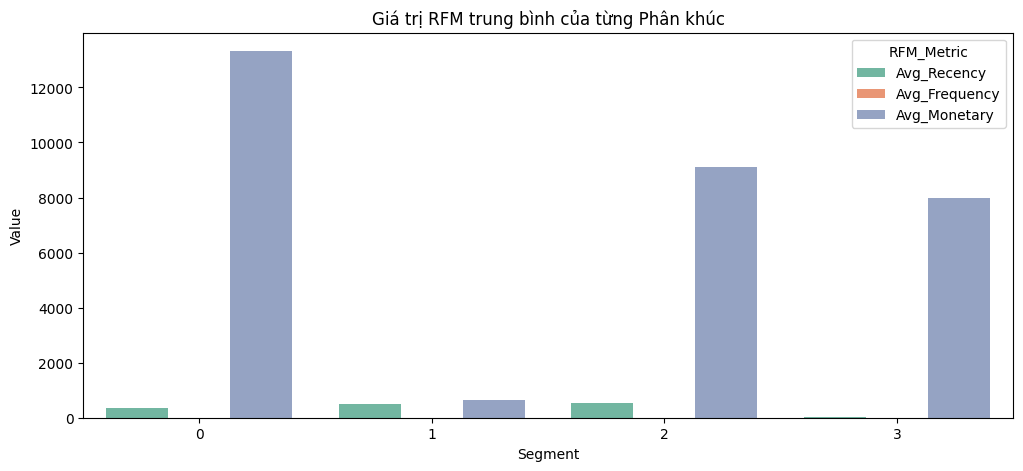

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Recency', y='Monetary', hue='Segment', data=rfm_df,
    palette='viridis', size='Frequency', sizes=(50, 300)
)
plt.title('Phân khúc Khách hàng RFM (K-Means)')
plt.xlabel('Recency (Số ngày từ lần mua cuối)')
plt.ylabel('Monetary (Tổng chi tiêu)')
plt.legend(title='Phân khúc')
plt.grid(True)
plt.gca().invert_xaxis()  # Recency thấp là tốt (mới mua gần đây)

plt.show()

segment_analysis_melted = pd.melt(
    segment_analysis,
    id_vars=['Segment'],
    value_vars=['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary'],
    var_name='RFM_Metric',
    value_name='Value'
)

plt.figure(figsize=(12, 5))
sns.barplot(x='Segment', y='Value', hue='RFM_Metric',
            data=segment_analysis_melted, palette='Set2')
plt.title('Giá trị RFM trung bình của từng Phân khúc')
plt.show()

In [ ]:
segment_name_map = {
    3: 'Khách hàng Vàng (Champions)',
    0: 'Khách hàng Trung thành Ngủ quên (Loyalists)',
    2: 'Khách hàng Đã mất (Lost)',
    1: 'Khách hàng Nguy cơ & Giá trị Thấp (At Risk & Low Value)'
}

# Gán tên cho bảng phân tích
segment_analysis['Segment_Name'] = segment_analysis['Segment'].map(segment_name_map)

print("\n--- BẢNG PHÂN TÍCH ĐẶC ĐIỂM CÁC PHÂN KHÚC HOÀN CHỈNH ---")
final_analysis_table = segment_analysis.sort_values(by='Avg_Monetary', ascending=False)
print(final_analysis_table.to_markdown(index=False))

# --- 4. Gán tên phân khúc cho từng khách hàng ---
rfm_df['Segment_Name'] = rfm_df['Segment'].map(segment_name_map)

print("\n--- 5 Khách hàng đầu tiên với Tên Phân khúc được gán ---")
print(rfm_df[['USERID', 'Recency', 'Frequency', 'Monetary', 'Segment_Name']]
      .head().to_markdown(index=False))


--- BẢNG PHÂN TÍCH ĐẶC ĐIỂM CÁC PHÂN KHÚC HOÀN CHỈNH ---
|   Segment |   Count |   Avg_Recency |   Avg_Frequency |   Avg_Monetary |   Pct_of_Customers | Segment_Name                                            |
|----------:|--------:|--------------:|----------------:|---------------:|-------------------:|:--------------------------------------------------------|
|         0 |   15552 |        339.89 |            2.36 |       13322.4  |              28.17 | Khách hàng Trung thành Ngủ quên (Loyalists)             |
|         2 |   19189 |        534.29 |            1    |        9113.5  |              34.76 | Khách hàng Đã mất (Lost)                                |
|         3 |    6575 |         44.22 |            1.57 |        7972.72 |              11.91 | Khách hàng Vàng (Champions)                             |
|         1 |   13890 |        505.9  |            1.05 |         657.8  |              25.16 | Khách hàng Nguy cơ & Giá trị Thấp (At Risk & Low Value) |

--- 5 Khách hàng 

# Dự đoán hành vi của khách hàng

In [ ]:
# | Dự báo        | Y (Target)        | X (Features)                            | Model                  | Dữ liệu thực tế cần                |
# | ------------- | ----------------- | --------------------------------------- | ---------------------- | --------------------------------- |
# | Purchase Prob | PurchaseNextMonth | Recency, Frequency, Monetary, AvgBasket | RandomForestClassifier | Mua hàng thực tế tháng tới        |
# | CLV           | Monetary          | Recency, Frequency, Monetary, AvgBasket | LinearRegression       | Tổng chi tiêu thực tế             |
# | Churn Prob    | Churn             | Recency, Frequency, Monetary, AvgBasket | RandomForestClassifier | Khách ngừng mua thực tế           |
# | Revenue       | Revenue           | Chuỗi thời gian tổng doanh thu          | Prophet                | Doanh thu thực tế theo tháng      |

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


required_cols = {'USERID', 'ORDERID', 'TOTALPRICE', 'TOTALBASKET', 'DATE_'}
missing_cols = required_cols - set(df.columns)
if missing_cols:
    raise ValueError(f"Thiếu cột bắt buộc: {missing_cols}")

# =====================================================
# 2. Tạo feature RFM
# =====================================================
last_date = df['DATE_'].max()
rfm = (
    df.groupby('USERID')
    .agg({
        'DATE_': lambda x: (last_date - x.max()).days,
        'ORDERID': 'count',
        'TOTALPRICE': 'sum',
        'TOTALBASKET': 'mean'
    })
    .reset_index()
)
rfm.columns = ['USERID', 'Recency', 'Frequency', 'Monetary', 'AvgBasket']
numeric_features = ['Recency', 'Frequency', 'Monetary', 'AvgBasket']

# =====================================================
# 3. Clustering
# =====================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm[numeric_features])
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)
pca = PCA(n_components=2, random_state=42)
rfm[['PCA1', 'PCA2']] = pca.fit_transform(X_scaled)

# =====================================================
# 4. Labels
# =====================================================
rfm['PurchaseNextMonth'] = (rfm['Frequency'] > 1).astype(int)
rfm['Churn'] = (rfm['Recency'] > rfm['Recency'].median()).astype(int)
rfm['CLV'] = rfm['Monetary']

# =====================================================
# 5. Train models
# =====================================================
X = rfm[numeric_features]

# Purchase model
y_purchase = rfm['PurchaseNextMonth']
X_train, X_test, y_train, y_test = train_test_split(X, y_purchase, test_size=0.2, random_state=42, stratify=y_purchase)
purchase_model = RandomForestClassifier(n_estimators=100, random_state=42)
purchase_model.fit(X_train, y_train)
rfm['Purchase_Prob'] = purchase_model.predict_proba(X)[:, 1]

# CLV model
y_clv = rfm['Monetary']
X_train, X_test, y_train_clv, y_test_clv = train_test_split(X, y_clv, test_size=0.2, random_state=42)
clv_model = LinearRegression()
clv_model.fit(X_train, y_train_clv)
rfm['CLV_Pred'] = clv_model.predict(X)

# Churn model
y_churn = rfm['Churn']
try:
    X_train, X_test, y_train_churn, y_test_churn = train_test_split(X, y_churn, test_size=0.2, random_state=42, stratify=y_churn)
except ValueError:
    X_train, X_test, y_train_churn, y_test_churn = train_test_split(X, y_churn, test_size=0.2, random_state=42)
churn_model = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42)
churn_model.fit(X_train, y_train_churn)
rfm['Churn_Prob'] = churn_model.predict_proba(X)[:, 1]

# =====================================================
# 6. Merge predictions
# =====================================================
# Ensure the 'Month' column is created before merging
df['Month'] = df['DATE_'].dt.to_period('M').dt.to_timestamp()

# Perform the merge
df = df.merge(
    rfm[['USERID', 'Purchase_Prob', 'CLV_Pred', 'Churn_Prob', 'Cluster']],
    on='USERID', how='left'
)

# =====================================================
# 7. Aggregate by Month
# =====================================================
rfm_monthly = (
    df.groupby('Month')[['Purchase_Prob', 'CLV_Pred', 'Churn_Prob']]
    .mean().reset_index()
)
monthly_revenue = (
    df.groupby('Month')['TOTALPRICE']
    .sum().reset_index().rename(columns={'TOTALPRICE': 'Revenue'})
)

# =====================================================
# 8. Forecast (v5 - Fixed inverse log)
# =====================================================
def safe_mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true = np.where(y_true == 0, np.nan, y_true)
    return np.nanmean(np.abs((y_true - y_pred) / y_true)) * 100

def preprocess_for_forecast(df_ts, value_col, smooth=True, use_log=False):
    df = df_ts[['Month', value_col]].copy()
    df['y'] = df[value_col]
    if smooth:
        df['y'] = df['y'].rolling(window=3, min_periods=1).mean()
    if use_log:
        df['y'] = np.log1p(df['y'])
    df = df.rename(columns={'Month': 'ds'}).dropna()
    return df

def forecast_ts(df_ts, value_col, periods=6, smooth=False, use_log=False):
    df_prophet = preprocess_for_forecast(df_ts, value_col, smooth, use_log)
    if df_prophet.shape[0] < 3:
        print(f"⚠️ Không đủ dữ liệu ({df_prophet.shape[0]}) để forecast {value_col}.")
        return None, None, None, None # Return None for all four values

    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.8,
        seasonality_mode='multiplicative'
    )
    model.fit(df_prophet)
    future = model.make_future_dataframe(periods=periods, freq='M')
    forecast = model.predict(future)

    # ✅ Inverse transform nếu có log
    if use_log:
        forecast['yhat'] = np.expm1(forecast['yhat'])
        df_prophet['y'] = np.expm1(df_prophet['y'])

    merged = forecast[['ds', 'yhat']].merge(df_prophet[['ds', 'y']], on='ds', how='inner')
    y_true, y_pred = merged['y'].values, merged['yhat'].values

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = safe_mape(y_true, y_pred)

    return forecast, mape, rmse, mae

# --- Forecast từng phần ---
forecast_purchase, mape_p, rmse_p, mae_p = forecast_ts(rfm_monthly, 'Purchase_Prob', smooth=True)
forecast_clv, mape_c, rmse_c, mae_c = forecast_ts(rfm_monthly, 'CLV_Pred', smooth=False, use_log=True)
forecast_churn, mape_ch, rmse_ch, mae_ch = forecast_ts(rfm_monthly, 'Churn_Prob', smooth=True)
forecast_revenue, mape_r, rmse_r, mae_r = forecast_ts(monthly_revenue, 'Revenue', smooth=True, use_log=True)

# =====================================================
# 9. Plot forecast vs actual
# =====================================================
def plot_forecast(df_actual, forecast, value_col, title):
    if forecast is None:
        print(f"⚠️ Không có forecast để hiển thị cho {title}")
        return
    fig = px.line(title=title)
    fig.add_scatter(x=df_actual['Month'], y=df_actual[value_col], mode='lines+markers', name='Actual')
    fig.add_scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast')
    fig.show()

plot_forecast(rfm_monthly, forecast_purchase, 'Purchase_Prob', '🔹 Dự báo Khả năng Mua hàng 6 tháng tới')
plot_forecast(rfm_monthly, forecast_clv, 'CLV_Pred', '🔹 Dự báo CLV 6 tháng tới')
plot_forecast(rfm_monthly, forecast_churn, 'Churn_Prob', '🔹 Dự báo Churn 6 tháng tới')
plot_forecast(monthly_revenue, forecast_revenue, 'Revenue', '🔹 Dự báo Doanh thu 6 tháng tới')

# =====================================================
# 10. In kết quả
# =====================================================
def pretty_print_metric(name, mape, rmse, mae):
    if mape is None:
        print(f"{name}: ⚠️ Không đủ dữ liệu để đánh giá.")
    else:
        warn = " ⚠️" if mape > 100 else ""
        print(f"{name}:{warn} MAPE={mape:.2f}% | RMSE={rmse:.4f} | MAE={mae:.4f}")

# 👉 Đây là nơi in ra các kết quả sau khi mô hình Prophet chạy xong
pretty_print_metric("Dự báo Khả năng Mua hàng", mape_p, rmse_p, mae_p)
pretty_print_metric("Dự báo CLV", mape_c, rmse_c, mae_c)
pretty_print_metric("Dự báo Churn", mape_ch, rmse_ch, mae_ch)
pretty_print_metric("Dự báo Doanh thu", mape_r, rmse_r, mae_r)

INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo7corp5s/yfip55mu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo7corp5s/1awpmosq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30931', 'data', 'file=/tmp/tmpo7corp5s/yfip55mu.json', 'init=/tmp/tmpo7corp5s/1awpmosq.json', 'output', 'file=/tmp/tmpo7corp5s/prophet_modeleefbo2_g/prophet_model-20251018072009.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:20:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:20:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead

Dự báo Khả năng Mua hàng: MAPE=0.00% | RMSE=0.0000 | MAE=0.0000
Dự báo CLV: MAPE=0.00% | RMSE=0.0384 | MAE=0.0363
Dự báo Churn: MAPE=0.00% | RMSE=0.0000 | MAE=0.0000
Dự báo Doanh thu: MAPE=0.01% | RMSE=984.4205 | MAE=981.4659
